In [1]:
from datetime import datetime
from matplotlib import pyplot as plt
import pandas as pd
from sentiment_anomaly.db import session, Comment

In [2]:
db = session()
comments = db.query(Comment)
comments.count()

295359

## Swear Index

This valuable sentiment metric tracks the ratio of reddit comments including the word _fuck_ to comments that don't, per comment-hour over time.

In [3]:
fuck = "%{}%".format('fuck')
from sqlalchemy import func
swear_comments = db.query(Comment).filter(func.lower(Comment.body).like(fuck)).order_by(Comment.created_utc)
all_comments = db.query(Comment).order_by(Comment.created_utc)
swear_comments.count()

20843

In [4]:
def per_comment_hour(comments):
    df = pd.DataFrame()
    df['time'] = [datetime.fromtimestamp(post.created_utc) for post in comments]
    df['hod'] = ["{:4d}{:02d}{:02d}{:02d}".format(r.year, r.month, r.day, r.hour) for r in df.time]
    return pd.DataFrame(df.groupby('hod')["time"].count())

In [5]:
df_swear =  per_comment_hour(swear_comments)
dfv = df_swear.merge(per_comment_hour(all_comments), how='left', on=['hod'])
dfv['swear_index'] = dfv.time_x / (dfv.time_y - dfv.time_x)
dfv.head()

,time_x,time_y,swear_index
hod,,,
2021020609,1,28,0.037037
2021020610,16,156,0.114286
2021020611,19,197,0.106742
2021020612,26,247,0.117647
2021020613,38,445,0.093366


Drop the first and last hour where sampling is partial

In [6]:
hour_index = dfv.index.tolist()
dfv = dfv.drop([hour_index[0], hour_index[-1]])

Plot the Swear Index

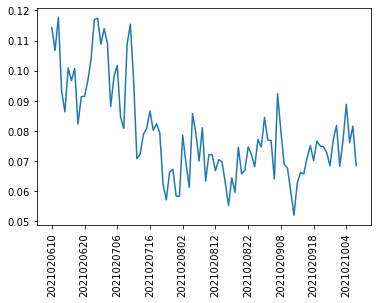

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(dfv['swear_index'])
plt.xticks(rotation='vertical', ticks=dfv.index.tolist()[::10])
plt.show()